# 07 — Feature Importance Analysis

This notebook provides interpretation for the feature importance and permutation importance for the Random forest, XGBoost and Decision Tree models similar to Table 2 in Jannani et al. paper. 

C:\Users\angel\AppData\Local\Temp\ipykernel_11420\2315664401.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_top18 = df_top18.applymap(lambda x: f"{x:.3f}")


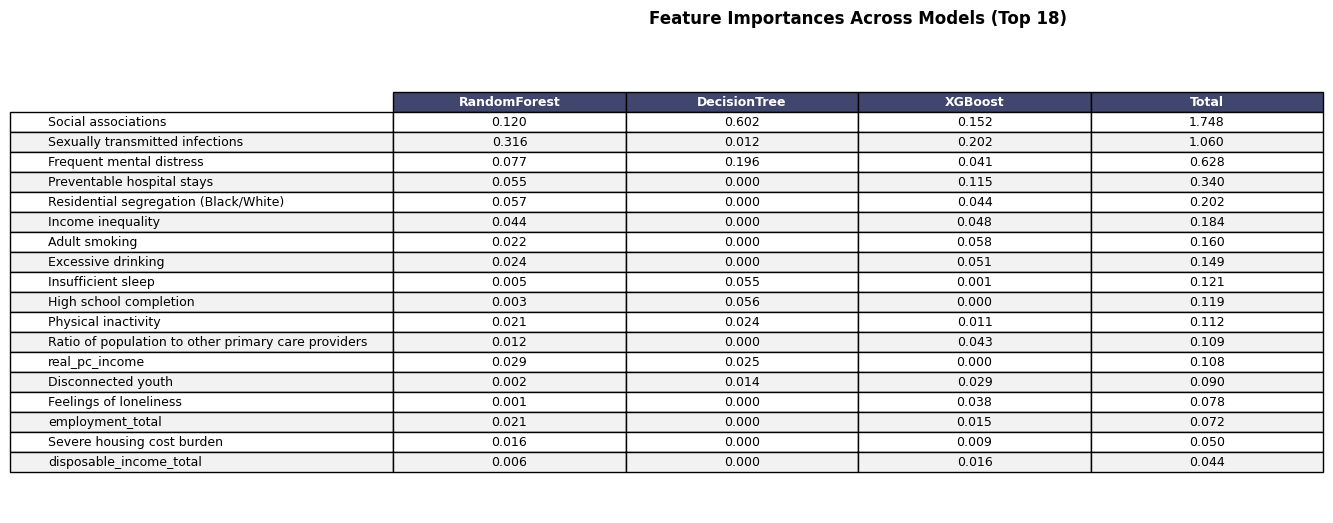

In [1]:
import joblib, os
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
import warnings

root = Path.cwd().parent  
sys.path.append(str(root / "src"))
from config import CHR_METRICS_NAMES

# Load all feature names from CSV
all_features = pd.read_csv("../results/norm_predictors/final_predictor_index_5_years.csv").columns

models_info = {
    "RandomForest": "../results/models/RandomForestRegress_best.joblib",
    "DecisionTree": "../results/models/DecisionTreeRegress_best.joblib",
    "XGBoost": "../results/models/XGBoostRegress_best.joblib",
}

importance_data = {}

for name, path in models_info.items():
    model = joblib.load(path)
    n_feats = len(model.feature_importances_)

    # Try to get feature names safely
    if hasattr(model, "feature_names_in_"):
        feature_names = model.feature_names_in_
    else:
        # fallback if XGBoost lost names — use first n_feats from CSV
        feature_names = all_features[:n_feats]

    importance_data[name] = pd.Series(model.feature_importances_, index=feature_names)

# Merge all importances into one DataFrame
df = pd.concat(importance_data, axis=1)

# Compute total and sort
df["Total"] = df.sum(axis=1)
df = df.round(3).sort_values(by="Total", ascending=False)

# Remove "State" if present
if "State" in df.index:
    df = df.drop("State")
# Replace machine names with human-readable names
df.index = df.index.str.replace("_norm", "", regex=False)
df.index = df.index.map(lambda x: CHR_METRICS_NAMES.get(x, x))
df["Total"] = df.sum(axis=1)
df = df.round(3).sort_values(by="Total", ascending=False)
df_top18 = df.head(18)
df_top18 = df_top18.applymap(lambda x: f"{x:.3f}")

# Set up figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
ax.axis('tight')

# Create table
table = ax.table(
    cellText=df_top18.values,
    colLabels=df_top18.columns,
    rowLabels=df_top18.index,
    cellLoc='center',
    loc='center'
)

# Style adjustments
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

# Add alternating row colors for readability
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')  # dark header
    elif row % 2 == 0:
        cell.set_facecolor('#f2f2f2')  # light gray for even rows
    else:
        cell.set_facecolor('#ffffff')  # white for odd rows

plt.title("Feature Importances Across Models (Top 18)", fontsize=12, weight='bold', pad=20)

# Save to file
output_path = os.path.join("../results/plots", "Feature_Importances_Table_5yrs.png")
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()


C:\Users\angel\AppData\Local\Temp\ipykernel_11420\2140082563.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_perm_top18 = df_perm_top18.applymap(lambda x: f"{x:.3f}")


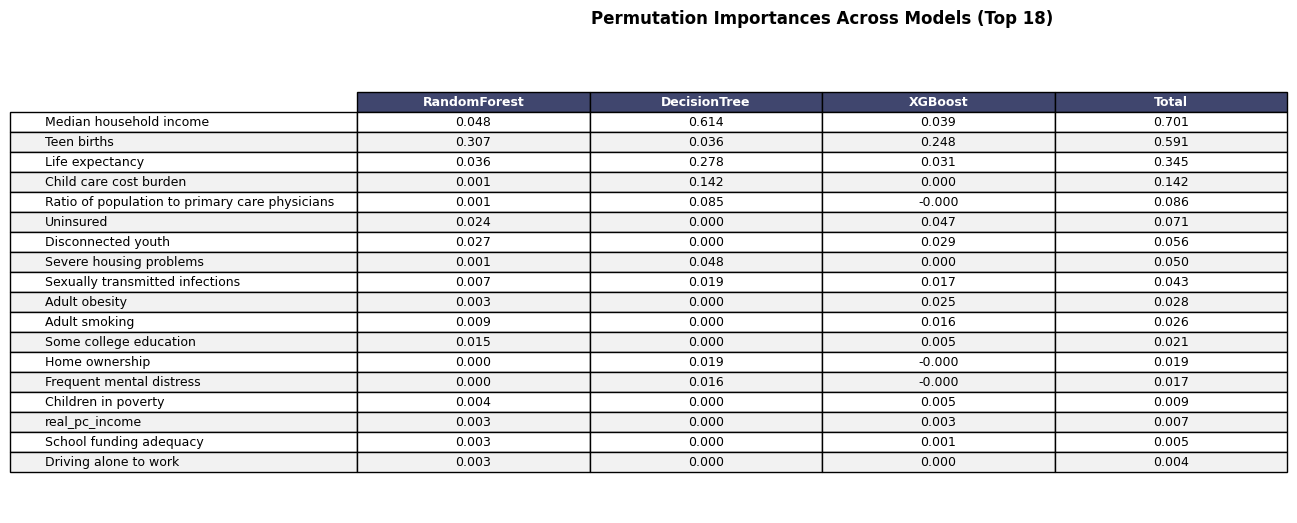

In [2]:
# === Permutation Importance Calculation ===
# Warning: This can take a while to compute depending on data size and model complexity.
# Takes approximately 2-4 minutes to run.
warnings.filterwarnings("ignore", message="X has feature names")
def fill_in_missing_values(X_train, X_test):
    # Impute missing values using mean strategy
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    return X_train, X_test

# Paths
models_info = {
    "RandomForest": "../results/models/RandomForestRegress_best.joblib",
    "DecisionTree": "../results/models/DecisionTreeRegress_best.joblib",
    "XGBoost": "../results/models/XGBoostRegress_best.joblib",
}

# Load test data
X = pd.read_csv("../results/norm_predictors/final_predictor_index_5_years.csv")
y_test = pd.read_csv("../results/norm_targets/final_target_index_5_years.csv")["target_index"]

features = [c for c in X.columns if c.endswith("_norm")]
X = X[features]
_, X_test_imputed = fill_in_missing_values(X, X)  # or use X_train from your split if you have it

# Convert back to DataFrame (since the function returns np arrays)
X_test = pd.DataFrame(X_test_imputed, columns=X.columns)

# Drop 'State' or ID columns if present
if "State" in X_test.columns:
    X_test = X_test.drop(columns=["State"])

# Compute permutation importances
perm_results = {}

for name, path in models_info.items():
    model = joblib.load(path)

    # Get the features actually used during training
    if hasattr(model, "feature_names_in_"):
        model_features = model.feature_names_in_
    else:
        # XGBoost sometimes drops feature names; fallback to first n columns
        n_feats = len(model.feature_importances_)
        model_features = X_test.columns[:n_feats]

    # Filter X_test to only those columns
    X_test = X_test[model_features]

    # Compute permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, scoring="r2", random_state=42)
    perm_results[name] = pd.Series(result.importances_mean, index=model_features)

# Merge results into one table
df_perm = pd.concat(perm_results, axis=1)
df_perm["Total"] = df_perm.sum(axis=1)
df_perm = df_perm.sort_values(by="Total", ascending=False)

# Clean names and map to CHR_METRICS_NAMES
df_perm.index = df_perm.index.str.replace("_norm", "", regex=False)
df_perm.index = df_perm.index.map(lambda x: CHR_METRICS_NAMES.get(x, x))

# Round to 7 decimal places (like the paper)
df_perm = df_perm.round(7)

# Top 18 features
df_perm_top18 = df_perm.head(18)
df_perm_top18 = df_perm_top18.applymap(lambda x: f"{x:.3f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
ax.axis('tight')

table = ax.table(
    cellText=df_perm_top18.values,
    colLabels=df_perm_top18.columns,
    rowLabels=df_perm_top18.index,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

# Alternating row colors
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')
    elif row % 2 == 0:
        cell.set_facecolor('#f2f2f2')
    else:
        cell.set_facecolor('#ffffff')

plt.title("Permutation Importances Across Models (Top 18)", fontsize=12, weight='bold', pad=20)

# Save table
output_path = os.path.join("../results/plots", "Permutation_Importances_Table_5yrs.png")
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()